# Imports

In [ ]:
!pip install timm

     |████████████████████████████████| 376 kB 4.9 MB/s 


In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL

import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

from timm import create_model

# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!mkdir /content/dataset

In [ ]:
!unzip '/content/drive/MyDrive/datasets/cats_and_dogs/cats_and_dogs.zip' -d '/content/dataset'

Archive:  /content/drive/MyDrive/datasets/cats_and_dogs/cats_and_dogs.zip
  inflating: /content/dataset/cats_and_dogs/test/dogs/dog.2083.jpg  
  inflating: /content/dataset/cats_and_dogs/test/dogs/dog.2055.jpg  
  inflating: /content/dataset/cats_and_dogs/test/cats/cat.2004.jpg  
  inflating: /content/dataset/cats_and_dogs/test/cats/cat.2098.jpg  
  inflating: /content/dataset/cats_and_dogs/test/cats/cat.2064.jpg  
  inflating: /content/dataset/cats_and_dogs/test/dogs/dog.2069.jpg  
  inflating: /content/dataset/cats_and_dogs/test/cats/cat.2089.jpg  
  inflating: /content/dataset/cats_and_dogs/test/cats/cat.2061.jpg  
  inflating: /content/dataset/cats_and_dogs/test/cats/cat.2063.jpg  
  inflating: /content/dataset/cats_and_dogs/test/cats/cat.2049.jpg  
  inflating: /content/dataset/cats_and_dogs/test/dogs/dog.2096.jpg  
  inflating: /content/dataset/cats_and_dogs/test/cats/cat.2060.jpg  
  inflating: /content/dataset/cats_and_dogs/test/dogs/dog.2082.jpg  
  inflating: /content/dataset

# Setup

In [ ]:
# Define transforms for test
IMG_SIZE = (224, 224)
NORMALIZE_MEAN = (0.5, 0.5, 0.5)
NORMALIZE_STD = (0.5, 0.5, 0.5)
transforms = [
              T.Resize(IMG_SIZE),
              T.ToTensor(),
              T.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
              ]

transforms = T.Compose(transforms)

In [ ]:
model_name = "vit_base_patch16_224"
model = create_model(model_name, pretrained=True)

In [ ]:
# ImageNet Labels
!wget https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
imagenet_labels = dict(enumerate(open('ilsvrc2012_wordnet_lemmas.txt')))

--2021-11-15 15:54:25--  https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.210.128, 173.194.211.128, 173.194.212.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.210.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21675 (21K) [text/plain]
Saving to: ‘ilsvrc2012_wordnet_lemmas.txt’

ilsvrc2012_wordnet_ 100%[===================>]  21.17K  --.-KB/s    in 0s      

2021-11-15 15:54:25 (104 MB/s) - ‘ilsvrc2012_wordnet_lemmas.txt’ saved [21675/21675]



In [ ]:
img = PIL.Image.open('/content/dataset/cats_and_dogs/validation/dogs/dog.2001.jpg')
img_tensor = transforms(img).unsqueeze(0)

# Show image inference



In [ ]:
# end-to-end inference
output = model(img_tensor)

American_Staffordshire_terrier, Staffordshire_terrier, American_pit_bull_terrier, pit_bull_terrier



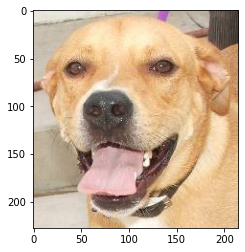

In [ ]:
# image inference
print(imagenet_labels[int(torch.argmax(output))])
plt.imshow(img)

# Vision Transformer (ViT) 

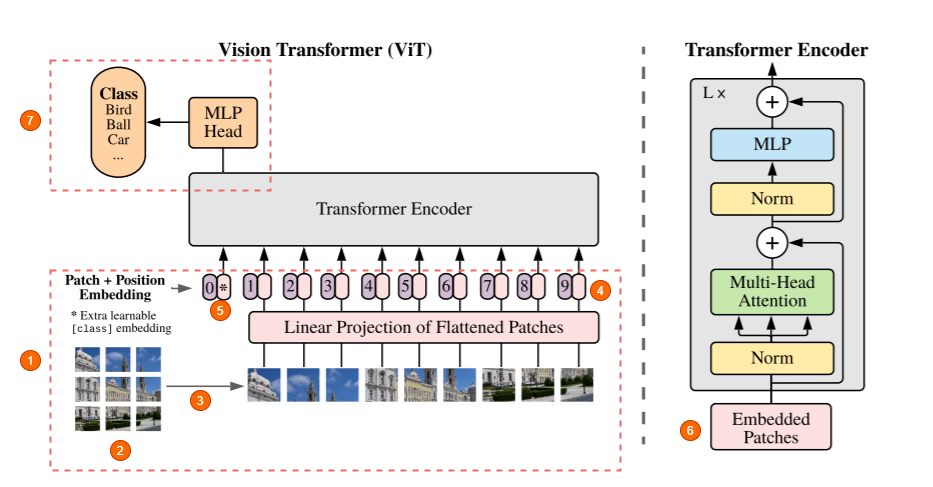

## Prepare Image Patches

### Split Image in Patches

(1) The ViT Architecture is based on Transformer architecture.

(2) The images are breaking down into fixed size patches, for example 16x16 or 32x32. More patches means more simpler it is to train the networks as the patches themselves get smaller.

In [ ]:
patches = model.patch_embed(img_tensor)  # patch embedding convolution
print("Image tensor: ", img_tensor.shape)
print("Patch embeddings: ", patches.shape)

Image tensor:  torch.Size([1, 3, 224, 224])
Patch embeddings:  torch.Size([1, 196, 768])


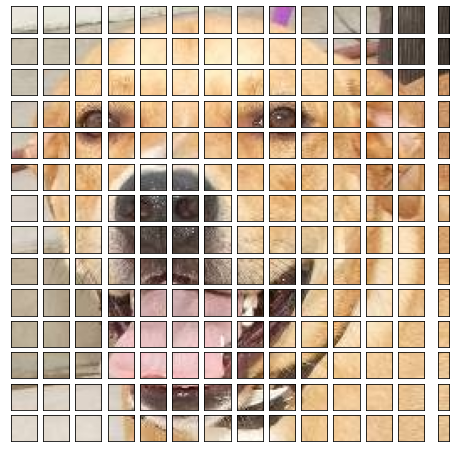

In [ ]:
# view image patches
fig = plt.figure(figsize=(8, 8))
fig.add_axes()
img = np.asarray(img)
for i in range(0, 196):
    x = i % 14
    y = i // 14
    patch = img[y*16:(y+1)*16, x*16:(x+1)*16]
    ax = fig.add_subplot(14, 14, i+1)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(patch)

### Add Position Embedding

(3) The patches are then unrolled (flattened) and sent for further processing into the network.

(4) Unlike NNs the model has no idea about the position of the samples in the sequence, so each sample is a patch from the input image. The image is fed along with a positional embedding vector and into the encoder, letting the model to learn about the image structure.



In [ ]:
# position embedding
pos_embed = model.pos_embed
print(pos_embed.shape)

torch.Size([1, 197, 768])


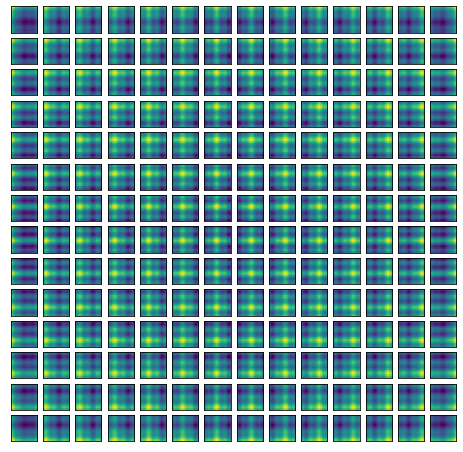

In [ ]:
# Visualize position embedding similarities.
# One cell shows cos similarity between an embedding and all the other embeddings.
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
fig = plt.figure(figsize=(8, 8))
for i in range(1, pos_embed.shape[1]):
    sim = F.cosine_similarity(pos_embed[0, i:i+1], pos_embed[0, 1:], dim=1)
    sim = sim.reshape((14, 14)).detach().cpu().numpy()
    ax = fig.add_subplot(14, 14, i)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(sim)

### Add Extra Token

(5) There is also a special token at the start of the embedding vector.

In [ ]:
transformer_input = torch.cat((model.cls_token, patches), dim=1) + pos_embed
print("Transformer input: ", transformer_input.shape)

Transformer input:  torch.Size([1, 197, 768])


## Transformer Encoder

(6) The embedded patches are combined with the positional embedding vector and that gets fed into the Tranformer.

- N (=197) embedded vectors are fed to the L (=12) series encoders. 
- The vectors are divided into query, key and value after expanded by an fc layer. 
- q, k and v are further divided into H (=12) and fed to the parallel attention heads. 
- Outputs from attention heads are concatenated to form the vectors whose shape is the same as the encoder input.
- The vectors go through an fc, a layer norm and an MLP block that has two fc layers.

In [ ]:
print("Input tensor to Transformer (z0): ", transformer_input.shape)
x = transformer_input.clone()
for i, blk in enumerate(model.blocks):
    print("Entering the Transformer Encoder {}".format(i))
    x = blk(x)
x = model.norm(x)
transformer_output = x[:, 0]
print("Output vector from Transformer (z12-0):", transformer_output.shape)

Input tensor to Transformer (z0):  torch.Size([1, 197, 768])
Entering the Transformer Encoder 0
Entering the Transformer Encoder 1
Entering the Transformer Encoder 2
Entering the Transformer Encoder 3
Entering the Transformer Encoder 4
Entering the Transformer Encoder 5
Entering the Transformer Encoder 6
Entering the Transformer Encoder 7
Entering the Transformer Encoder 8
Entering the Transformer Encoder 9
Entering the Transformer Encoder 10
Entering the Transformer Encoder 11
Output vector from Transformer (z12-0): torch.Size([1, 768])


### Multi-head attention block

In [ ]:
print("Transformer Multi-head Attention block:")
attention = model.blocks[0].attn
print(attention)
print("input of the transformer encoder:", transformer_input.shape)

Transformer Multi-head Attention block:
Attention(
  (qkv): Linear(in_features=768, out_features=2304, bias=True)
  (attn_drop): Dropout(p=0.0, inplace=False)
  (proj): Linear(in_features=768, out_features=768, bias=True)
  (proj_drop): Dropout(p=0.0, inplace=False)
)
input of the transformer encoder: torch.Size([1, 197, 768])


In [ ]:
# fc layer to expand the dimension
transformer_input_expanded = attention.qkv(transformer_input)[0]
print("expanded to: ", transformer_input_expanded.shape)

expanded to:  torch.Size([197, 2304])


In [ ]:
# Split qkv into mulitple q, k, and v vectors for multi-head attantion
qkv = transformer_input_expanded.reshape(197, 3, 12, 64)  # (N=197, (qkv), H=12, D/H=64)
print("split qkv : ", qkv.shape)
q = qkv[:, 0].permute(1, 0, 2)  # (H=12, N=197, D/H=64)
k = qkv[:, 1].permute(1, 0, 2)  # (H=12, N=197, D/H=64)
kT = k.permute(0, 2, 1)  # (H=12, D/H=64, N=197)
print("transposed ks: ", kT.shape)

split qkv :  torch.Size([197, 3, 12, 64])
transposed ks:  torch.Size([12, 64, 197])


Attention matrix:  torch.Size([12, 197, 197])


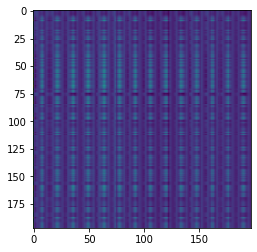

In [ ]:
# Show attention Matrix
attention_matrix = q @ kT
print("Attention matrix: ", attention_matrix.shape)
plt.imshow(attention_matrix[3].detach().cpu().numpy())

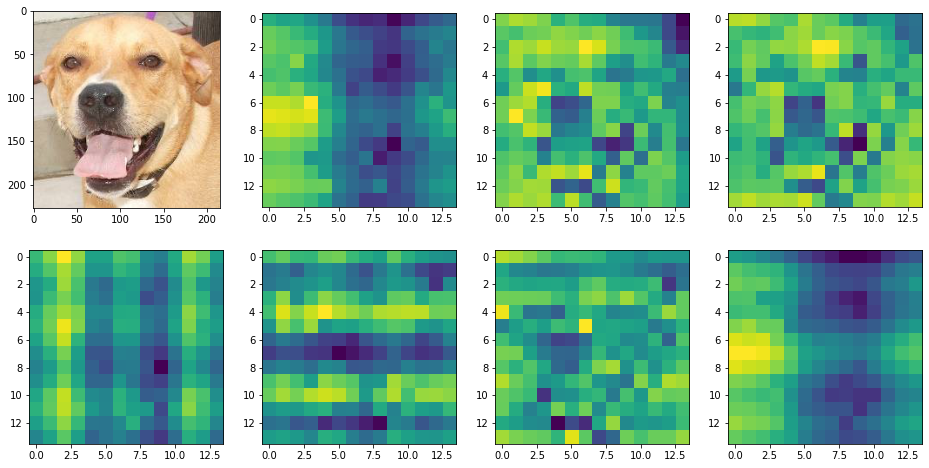

In [ ]:
# Visualize attention matrix
fig = plt.figure(figsize=(16, 8))
fig.add_axes()
img = np.asarray(img)
ax = fig.add_subplot(2, 4, 1)
ax.imshow(img)
for i in range(7):  # visualize the 100th rows of attention matrices in the 0-7th heads
    attn_heatmap = attention_matrix[i, 100, 1:].reshape((14, 14)).detach().cpu().numpy()
    ax = fig.add_subplot(2, 4, i+2)
    ax.imshow(attn_heatmap)

## MLP Head

(7) With the only difference being, instead of a decoder the output from the encoder is passed directly into a Feed Forward Neural Network (MLP Head) to obtain the classification output.

Classification head:  Linear(in_features=768, out_features=1000, bias=True)
Inference result : id = 180, label name = American_Staffordshire_terrier, Staffordshire_terrier, American_pit_bull_terrier, pit_bull_terrier



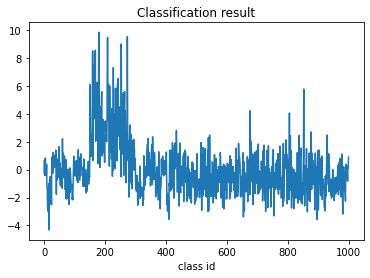

In [ ]:
print("Classification head: ", model.head)
result = model.head(transformer_output)
result_label_id = int(torch.argmax(result))
plt.plot(result.detach().cpu().numpy()[0])
plt.title("Classification result")
plt.xlabel("class id")
print("Inference result : id = {}, label name = {}".format(
    result_label_id, imagenet_labels[result_label_id]))